In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn import preprocessing
import datetime as dt
%matplotlib inline

In [52]:
data=pd.read_csv("C:/Users/dell/Desktop/semester1/Big Mess Data/Data.V7.csv", index_col="Date")

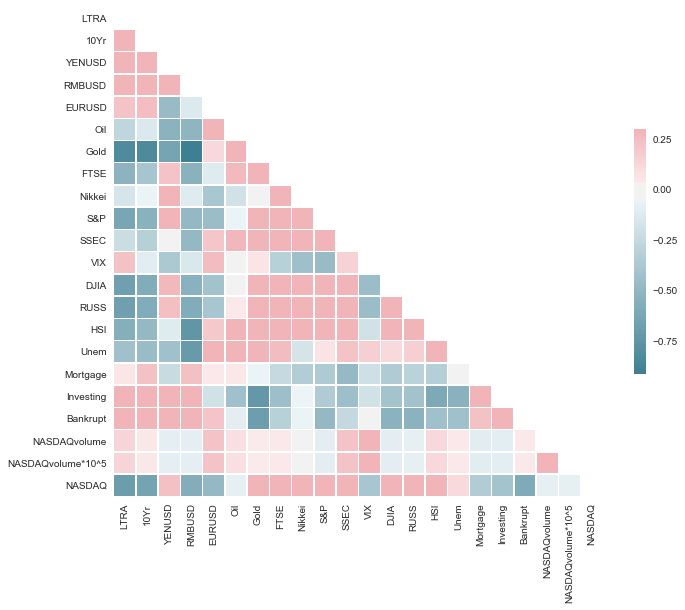

In [56]:
sns.set(style="white")
corr = data.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [54]:
Val1=['LTRA', '10Yr', "RMBUSD",'EURUSD']
Val2=['Unem','Mortgage', 'Investing', 'Bankrupt']
Val3=['YENUSD','Oil','VIX']
Val4=['S&P','Gold','RUSS','NASDAQ']
Val5=['DJIA', 'HSI','Nikkei','FTSE','SSEC',"NASDAQvolume*10^5"]

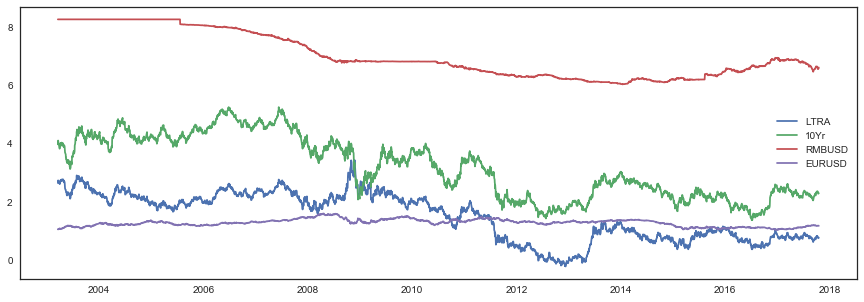

In [57]:
plt.figure(figsize=(15,5))
for i in Val1:
    plt.plot([dt.datetime.strptime(d,'%Y-%m-%d').date() for d in data.index],data[i].values, label=i)
plt.legend(loc="best")

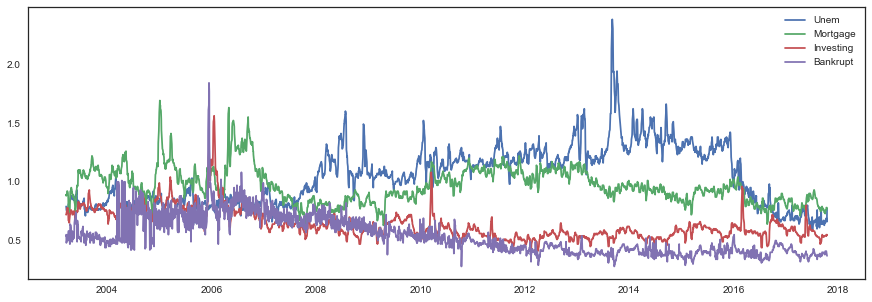

In [60]:
plt.figure(figsize=(15,5))
for i in Val2:
    plt.plot([dt.datetime.strptime(d,'%Y-%m-%d').date() for d in data.index],data[i].values, label=i)
plt.legend(loc="best")

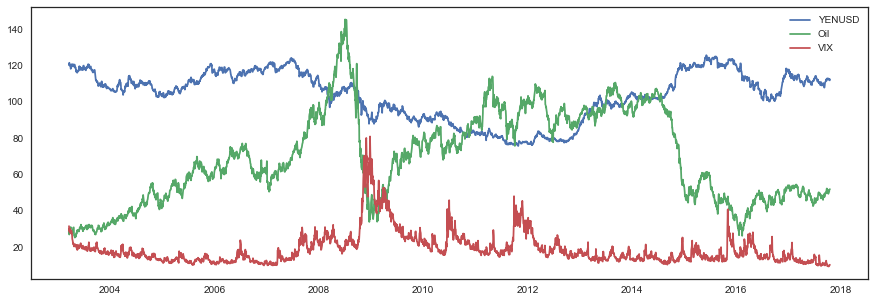

In [61]:
plt.figure(figsize=(15,5))
for i in Val3:
    plt.plot([dt.datetime.strptime(d,'%Y-%m-%d').date() for d in data.index],data[i].values, label=i)
plt.legend(loc="best")

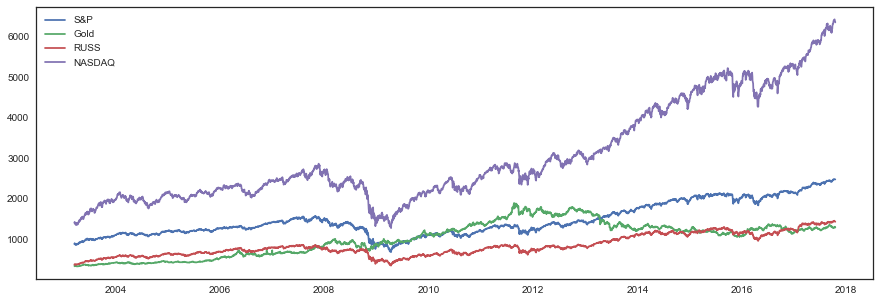

In [63]:
plt.figure(figsize=(15,5))
for i in Val4:
    plt.plot([dt.datetime.strptime(d,'%Y-%m-%d').date() for d in data.index],data[i].values, label=i)
plt.legend(loc="best")

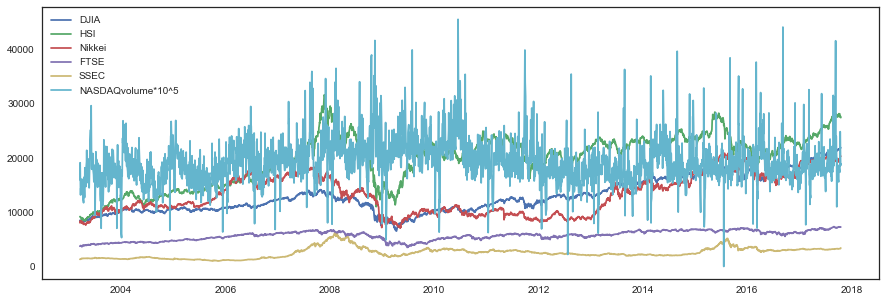

In [64]:
plt.figure(figsize=(15,5))
for i in Val5:
    plt.plot([dt.datetime.strptime(d,'%Y-%m-%d').date() for d in data.index],data[i].values, label=i)
plt.legend(loc="best")

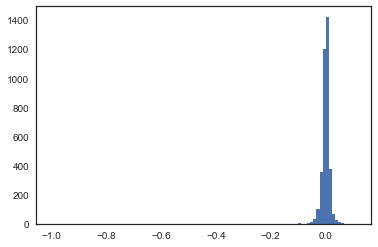

In [65]:
NASDAQLogreturn=[-1] #set the first value to -1 to align dataframe
temp=data["NASDAQ"].values
for i in range(1,len(temp)):
    NASDAQLogreturn.append(np.log(temp[i]/temp[i-1]))
data["NASDAQLogreturn"]=pd.Series(NASDAQLogreturn, index=data.index)
plt.hist(data["NASDAQLogreturn"], bins=100);

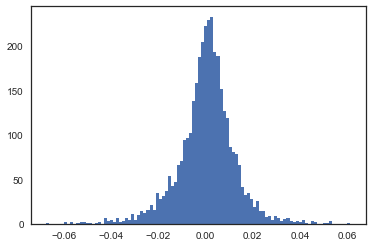

In [66]:
ReturnNoExtreme=sorted(data["NASDAQLogreturn"])[5:-5]
plt.hist(ReturnNoExtreme, bins=100);

In [67]:
# divide NASDAQ into up state(1) and down state(-1)
ret = data["NASDAQLogreturn"]
class_today = ret.copy()
class_today[ret >= 0] = 1
class_today[ret < 0] = -1

In [189]:
data["NASDAQ_class_today"] = class_today
data["NASDAQ_class_nextday"] = class_today.shift(-1)
data["NASDAQLogreturn_nextday"] = ret.shift(-1)
data.dropna(inplace=True)

In [69]:
data["NASDAQ_class_nextday"].value_counts()

 1.0    1987
-1.0    1630
Name: NASDAQ_class_nextday, dtype: int64

#### Use linear logistic regression as a preliminary analysis on the data

In [98]:
from sklearn import linear_model

In [217]:
n_train = 3000
train_data = data.iloc[:n_train, :]
test_data = data.iloc[n_train:, :]

X_train = train_data.iloc[:, :-4]
y_train = train_data.iloc[:, -2]
X_test = test_data.iloc[:, :-4]
y_test = test_data.iloc[:, -2]

In [218]:
# Use standardization to scale the input sample X in training set and use the same scaler to scale the testing set
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [219]:
logreg = linear_model.LogisticRegression(C=1e6)

In [220]:
logreg.fit(X_train_scaled,y_train)

LogisticRegression(C=1000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [221]:
predict_class = logreg.predict(X_test_scaled)

In [222]:
accuracy = logreg.score(X_test_scaled, y_test)
print("prediction accuracy of linear logistic regression: ", accuracy)

prediction accuracy of linear logistic regression:  0.551053484603


# Feature Selection by LASSO

We can use LASSO to select the features, and use feature to predict the next day's logreturn of NASDAQ index, then to judge the change of NASDAQ index.

In [223]:
n_train = 3000
train_data = data.iloc[:n_train, :]
test_data = data.iloc[n_train:, :]

X_train = train_data.iloc[:, :-3]
y_train = train_data.iloc[:, -1]
X_test = test_data.iloc[:, :-3]
y_test = test_data.iloc[:, -1]

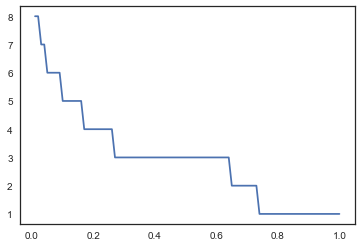

In [201]:
# LASSO
import matplotlib.pyplot as plt
from sklearn import linear_model
clf = linear_model.Lasso(alpha=0.1)
clf.fit(X_train, y_train)
num_features = []
alpha = np.linspace(0.01, 1,100)
for a in alpha:
    n = 0
    clf = linear_model.Lasso(alpha = a)
    clf.fit(X_train, y_train)
    for i in clf.coef_:
        if abs(i) > 10**(-20):
            n += 1
    num_features.append(n)
plt.plot(alpha, num_features)

In [202]:
#choose alpha = 0.2, 0.5, 1
#find the features

alpha = [0.01, 0.5, 1]
for a in alpha:
    clf = linear_model.Lasso(alpha = a)
    clf.fit(X_train, y_train)
    features = []
    for i in range(len(clf.coef_)):
        if abs(clf.coef_[i]) > 10**(-20):
            features.append(list(data)[i])
    print('When alpha = ',a,', features has',features)

When alpha =  0.01 , features has ['Gold', 'Nikkei', 'SSEC', 'DJIA', 'RUSS', 'HSI', 'NASDAQvolume', 'NASDAQ']
When alpha =  0.5 , features has ['DJIA', 'HSI', 'NASDAQvolume']
When alpha =  1 , features has ['NASDAQvolume']


So we can find that the changes of NASDAQ depends on other index instead of price of commodities. And the Gold is the only commodity that 'survive' from LASSO and feature selection.

Also, we can find that when we incease the alpha, NASDAQ dissappear before NASDAQ Volume, which means when we predict the changes of NASDAQ index, the volume is more important than NASDAQ price.

And NASDAQ volume is the most important feature.

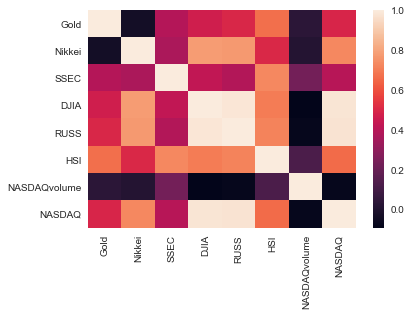

In [212]:
# find correlations of feature
clf = linear_model.Lasso(alpha = 0.01)
clf.fit(X_train, y_train)
features = []
for i in range(len(clf.coef_)):
    if abs(clf.coef_[i]) > 10**(-20):
        features.append(list(data)[i])
corr = data[features].corr()
sns.heatmap(corr)

It seems the correlation of the features are not high. We can apply this features in model. First we can find weather LASSO is a good method for classification.

In [225]:
# choose consider the rate
clf = linear_model.Lasso(alpha = 0.01)
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)
rate = 0
for i in range(len(X_test)):
    if y_predict[i]*y_test[i] >0:
        rate += 1
rate = rate/len(X_test)
rate

0.539708265802269

Obviously, the LASSO can't be used to predict the changes of NASDAQ.

# Linear Regression in Time Series

In the previous section, it seems the LASSO couldn't be used to predict the time series of stock price. We can check if other linear regression such as ridge could be effective.

In [231]:
from sklearn.linear_model import Ridge
clf = Ridge(alpha=1)
clf.fit(X_train, y_train) 
y_predict = clf.predict(X_test)
rate = 0
for i in range(len(X_test)):
    if y_predict[i]*y_test[i] >0:
        rate += 1
rate = rate/len(X_test)
rate

0.5089141004862237

The Linear Regression can't be used to predict the return of NASDAQ index.